# Analysis of PostgreSQL connections from HQDB0 for Jan 2017

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

                     Connections
Datetime                        
2017-01-01 00:00:00    31.600000
2017-01-01 00:05:00    23.900000
2017-01-01 00:10:00    23.727273
2017-01-01 00:15:00    16.700000
2017-01-01 00:20:00    13.272727


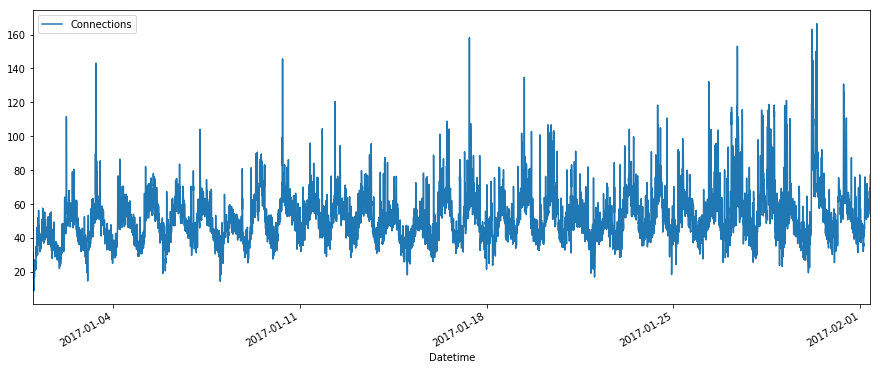

In [103]:
# Read in data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('postgres_connections.csv', parse_dates=[0], index_col='Datetime',date_parser=dateparse)
data_2017 = data['2017']
print data_2017.head()
data_2017.plot()

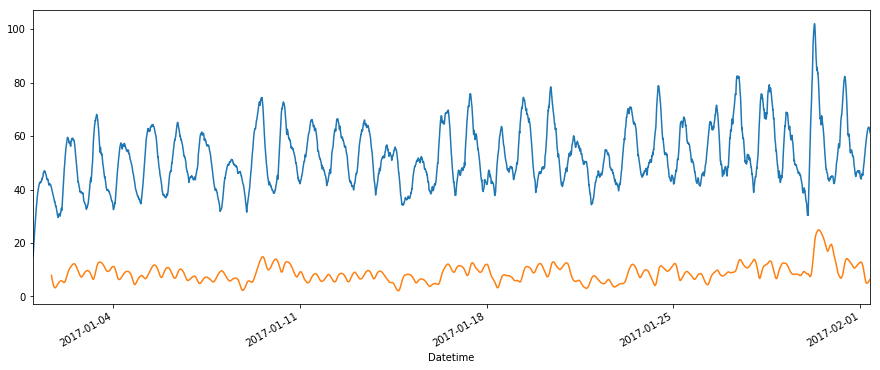

In [104]:
# Smooth data
from scipy.signal import savgol_filter
filtered_y = savgol_filter(data_2017['Connections'], 101, 3)
ts_filtered = pd.core.series.Series(filtered_y, data_2017.index)
ts_filtered.plot()

# Std deviation
stddev = ts_filtered.rolling(window=200, center=False).std()
stddev.dropna(inplace=True)
stddev.plot()


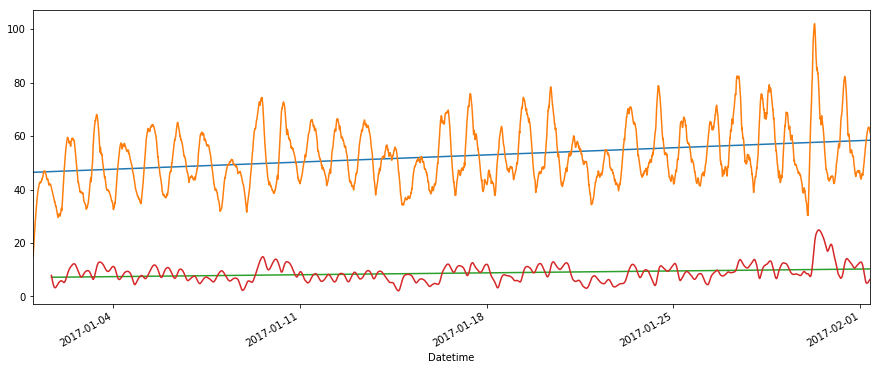

In [105]:
from scipy.stats import linregress
def linear_regress(timeseries, x_index):
    """
    Perform a linear regression on the timeseries data and return a new Series
    applying that model to the forecast index
    """
    time_as_int = timeseries.index.values.astype('timedelta64').astype('int')
    x_index_as_int = x_index.values.astype('timedelta64').astype('int')
    slope, intercept, r_value, p_value, std_err = linregress(time_as_int, timeseries.values)
    predict_y = intercept + slope * x_index_as_int
    return pd.core.series.Series(predict_y, x_index)

# Perform linear regressions on main DS & StdDev
conns_model = linear_regress(ts_filtered, ts_filtered.index)
conns_model.plot()
ts_filtered.plot()

stddev_model = linear_regress(stddev, stddev.index)
stddev_model.plot()
stddev.plot()


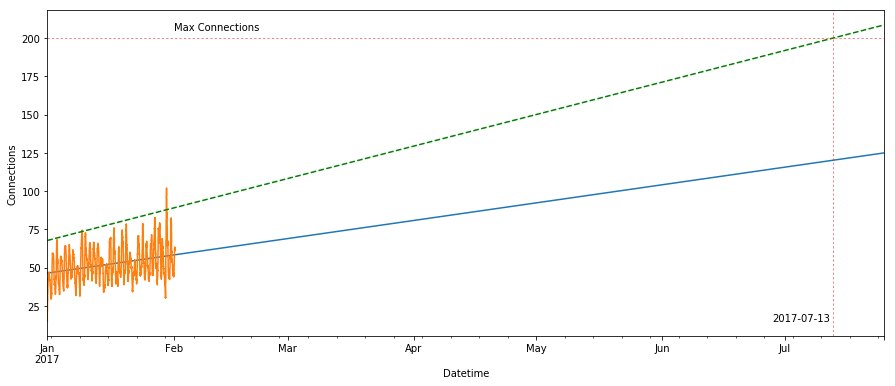

In [106]:
# Dates that we want to apply our forecasting over
forecast_dates = pd.date_range(ts_filtered.index.min(), '2018-01-01', freq='6H')
conns_forecast = linear_regress(ts_filtered, forecast_dates)

stddev_forecast = linear_regress(stddev, forecast_dates)
# upper bound = linear model + (stddev * 3)
upper_bound = conns_forecast + 3 * stddev_forecast

max_connections = 200
upper_date = upper_bound[upper_bound >= max_connections].index[0]
x_max = upper_date + 50

conns_forecast[:x_max].plot()
ts_filtered.plot()

upper_bound[:x_max].plot(style='g--')

plt.ylabel('Connections')
plt.axhline(y=max_connections, linewidth=0.5, color='r', linestyle=':')
plt.axvline(x=upper_date, linewidth=0.5, color='r', linestyle=':')
plt.text('2017-02-01', max_connections + 5, 'Max Connections')
plt.text(upper_date - 60, 15, upper_date.strftime('%Y-%m-%d'))